In [1]:
! pip3 install timm lightning albumentations scikit-learn
! pip3 uninstall opencv-python-headless --force
! pip3 install opencv-python --force-reinstall
! pip3 install filterpy


Usage:   
  pip3 uninstall [options] <package> ...
  pip3 uninstall [options] -r <requirements file> ...

no such option: --force
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: opencv-python━━━━━━━━━━━━━━━━━ 0/2 [numpy]
    Found existing installation: opencv-python 4.11.0.860/2 [numpy]
    Uninstalling opencv-python-4.11.0.86:━━━━━━━━━ 0/2 [numpy]
      Successfully uninstalled opencv-python-4.11.0.86 0/2 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning.pytorch as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

import timm
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset
import cv2

from ultralytics import YOLO
from pathlib import Path
import numpy as np
import pandas as pd

import random
import matplotlib.pyplot as plt
import shutil

import wandb

from sklearn.model_selection import train_test_split

/home/maxim/Desktop/Zebra-Test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Подготовка датасета
### Здесь мы извлекаем кропы отдельных блюд, используя обученную ранее модель, из двух видео, где они полные и где пустые (мы бы могли извлечь их используя разметку, но будем считать это заделом на будующую автоматическую досборку данных)

In [ ]:
model = YOLO("Zebra-test/experiments/silly/weights/best.pt")

def iou(box1, box2):
    """Compute IoU between two boxes in (x1, y1, x2, y2) format."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def extract_dishes(video_path, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    # Тут используем простой трекинг по iou что бы не потерять блюдо если оно двигалось, благо фпс позволяет
    dish_groups = []  # список: [{'bbox': [...], 'path': Path(...)}]

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        
        results = model.predict(source=frame, conf=0.5, stream=False)[0]
        dishes = results.boxes.xyxy.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)

        for i, cls in enumerate(classes):
            if cls != 0:  # только class 'dish'
                continue

            box = dishes[i].astype(int)  # [x1, y1, x2, y2]
            matched = False

            for group in dish_groups:
                if iou(box, group['bbox']) > 0.3:
                    matched = True
                    group['bbox'] = box 
                    crop = frame[box[1]:box[3], box[0]:box[2]]
                    if frame_idx % 30 == 0:
                        fname = f"frame{frame_idx:05d}.jpg"
                        cv2.imwrite(str(group['path'] / fname), crop)
                    break

            if not matched:
                group_id = len(dish_groups) + 1
                new_path = output_dir / f"dish{group_id}"
                new_path.mkdir(parents=True, exist_ok=True)
                crop = frame[box[1]:box[3], box[0]:box[2]]
                # Сохраним только каждый сотый кадр
                if frame_idx % 30 == 0:
                    fname = f"frame{frame_idx:05d}.jpg"
                    cv2.imwrite(str(new_path / fname), crop)
                dish_groups.append({'bbox': box, 'path': new_path})

        frame_idx += 1

    cap.release()
    print("✅ Готово! Изображения блюд сохранены в", output_dir)


for video, out in [("2_1.MOV", "full"), ("3_1.MOV", "full"), ("3_2.MOV", "empty")]:
    extract_dishes(Path('data/videos_raw')/video, Path('data/second_stage_dataset')/out)

### Визуализируем полученный датасет

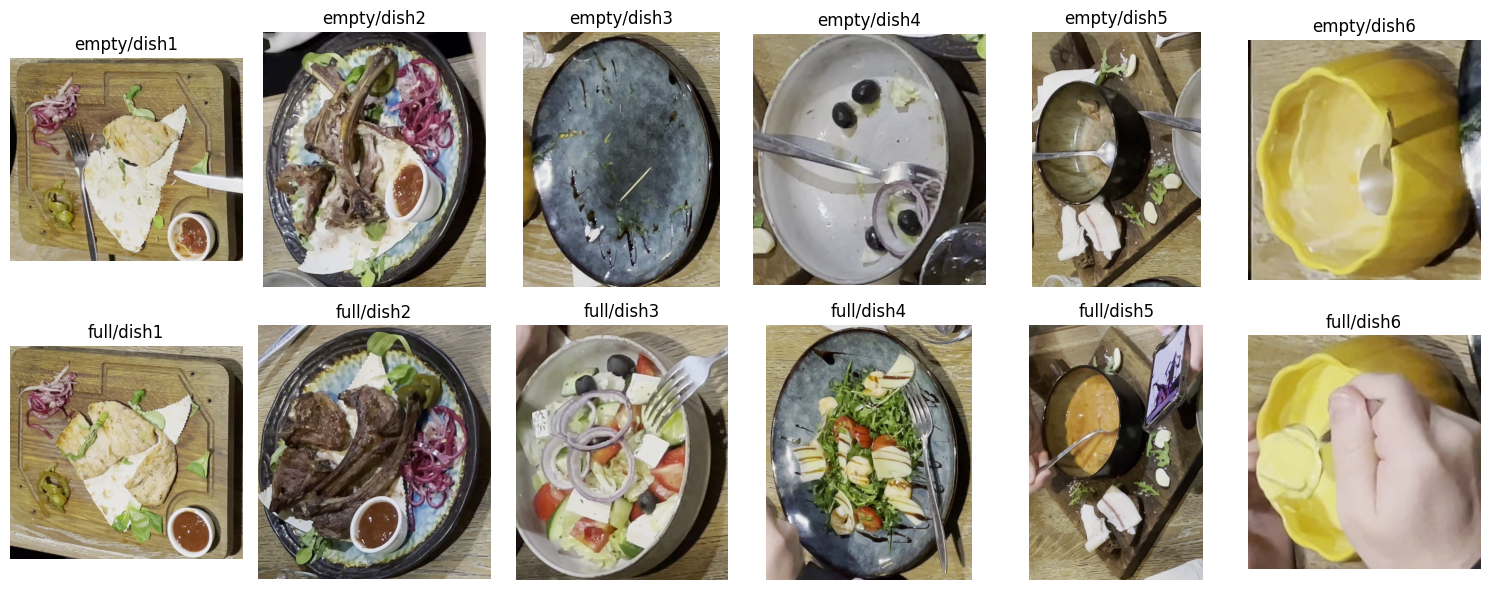

In [4]:
def visualize(base_dir):
    def load_random_image(folder: Path):
        images = list(folder.glob("*.jpg"))
        if not images:
            return None
        img_path = random.choice(images)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, img_path

    # Путь к извлечённым блюдам

    video_dirs = sorted([d for d in base_dir.iterdir() if d.is_dir()])

    fig, axs = plt.subplots(len(video_dirs), 6, figsize=(15, 3 * len(video_dirs)))
    axs = axs.reshape((len(video_dirs), 6))  # гарантируем 2D

    for i, video_dir in enumerate(video_dirs):
        dish_dirs = sorted([d for d in video_dir.iterdir() if d.is_dir()])
        for j in range(min(6, len(dish_dirs))):  # максимум 5 блюд на видео
            dish_dir = dish_dirs[j]
            img, path = load_random_image(dish_dir)
            if img is not None:
                axs[i, j].imshow(img)
                axs[i, j].set_title(f"{video_dir.name}/{dish_dir.name}")
            axs[i, j].axis('off')

        for j in range(len(dish_dirs), 6):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

base_dir = Path("data/second_stage_dataset")
visualize(base_dir)

### переименуем несовпавшие блюда

In [ ]:
base_dir = Path("data/second_stage_dataset/empty")

dish2 = base_dir / "dish2"
dish3 = base_dir / "dish3"
temp = base_dir / "dish_temp_swap"

dish2.rename(temp)
dish3.rename(dish2)
temp.rename(dish3)

### Сейчас все хорошо

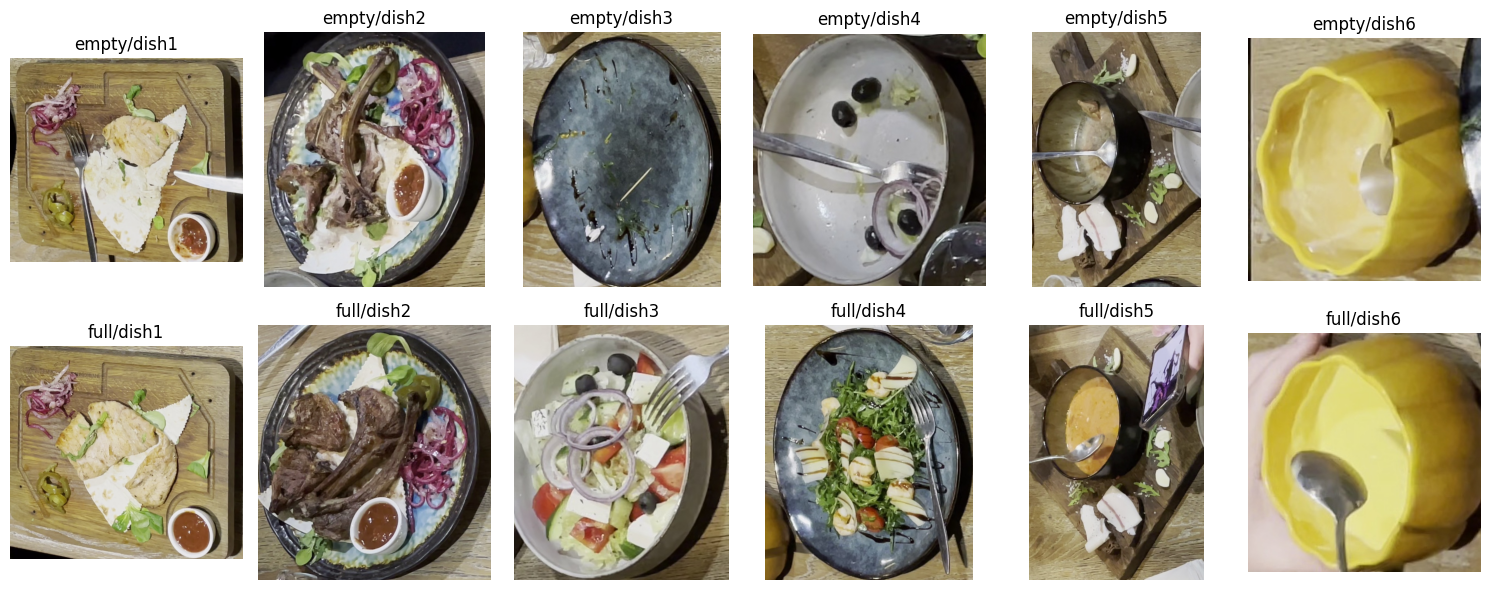

In [6]:
visualize(base_dir)

# Создаем датафрейм на основе папок, для удобства. балансируем классы через undersampling

In [7]:
base_dir = Path("data/second_stage_dataset")

dish_mapping = {
    'dish1': 'Chicken breast',
    'dish2': 'Ribs',
    'dish3': 'Salad with shrimps, arugula and cheese',
    'dish4': 'Greek salad',
    'dish5': 'Borsch',
    'dish6': 'Pumpkin soup',
}

data = []
for video_dir, fullness in [('full', 1.0), ('empty', 0.0)]:
    full_path = base_dir / video_dir
    if not full_path.exists():
        continue

    for dish_dir in full_path.iterdir():
        if not dish_dir.is_dir():
            continue

        dish_name = dish_dir.name
        dish_type = dish_mapping.get(dish_name, 'unknown')

        for img_path in dish_dir.glob("*.jpg"):
            data.append({
                'image_path': str(img_path.resolve()),
                'dish_name': dish_name,
                'dish_type': dish_type,
                'fullness': fullness
            })

df = pd.DataFrame(data)
print(df.head())


def undersample_by_group(df, group_cols):
    # Считаем размер каждой группы
    group_sizes = df.groupby(group_cols).size()
    min_size = group_sizes.min()

    # Балансируем: берём min_size примеров из каждой группы
    balanced_df = (
        df.groupby(group_cols, group_keys=False)
        .apply(lambda g: g.sample(min_size, random_state=42))
        .reset_index(drop=True)
    )
    return balanced_df

balanced_df = undersample_by_group(df, group_cols=["dish_type",])

# Проверим
print(balanced_df.groupby(["dish_type"]).size())

                                          image_path dish_name  \
0  /home/maxim/Desktop/Zebra-Test/data/second_sta...     dish1   
1  /home/maxim/Desktop/Zebra-Test/data/second_sta...     dish1   
2  /home/maxim/Desktop/Zebra-Test/data/second_sta...     dish1   
3  /home/maxim/Desktop/Zebra-Test/data/second_sta...     dish1   
4  /home/maxim/Desktop/Zebra-Test/data/second_sta...     dish1   

        dish_type  fullness  
0  Chicken breast       1.0  
1  Chicken breast       1.0  
2  Chicken breast       1.0  
3  Chicken breast       1.0  
4  Chicken breast       1.0  
dish_type
Borsch                                    175
Chicken breast                            175
Greek salad                               175
Pumpkin soup                              175
Ribs                                      175
Salad with shrimps, arugula and cheese    175
dtype: int64


/tmp/ipykernel_81042/1935791856.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min_size, random_state=42))


# Создаем кастомный датасет, определяем аугментации и создаем даталоадеры

In [8]:

class DishDataset(Dataset):
    def __init__(self, df, label_map, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        label = self.label_map[row["dish_type"]]
        fullness = row['fullness']
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(fullness, dtype=torch.float32).unsqueeze(-1)
    



In [9]:

label_map = {label:id for id, label in enumerate(df.dish_type.unique())}
inverse_label_map = {id:label for id, label in enumerate(df.dish_type.unique())}

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['fullness'], random_state=42)

train_transform = A.Compose([
    A.RandomScale(p = 0.2),
    A.Affine(
        scale=(0.8, 1.2),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-5, 5),
        shear=(-5, 5),
        interpolation=1,  # bilinear (cv2.INTER_LINEAR)
        cval=(0, 1),
        mode=cv2.BORDER_REFLECT101,
        p = 0.2,
        ),
    A.Rotate(p=0.5),
    A.RandomResizedCrop((224, 224), scale=(0.5, 1)),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p = 0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.GaussianBlur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])


val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

train_ds = DishDataset(train_df, label_map, transform=train_transform)
val_ds = DishDataset(val_df, label_map, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)

/tmp/ipykernel_81042/4216212698.py:8: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(


# Определяем модель

In [ ]:
class DishClassifier(L.LightningModule):
    def __init__(self,num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)

        self.embedding = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.SiLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1280, 512),
        )
        
        self.classifier = nn.Linear(512, num_classes)
        self.fullness = nn.Linear(512, 1)


    def forward(self, x):
        features = self.model(x)
        embedding = self.embedding(features)
        logits = self.classifier(embedding)
        fullness = self.fullness(embedding)
        return F.normalize(embedding, p=2), logits, F.sigmoid(fullness)
    
    def criterion(self, inputs, targets, inputs_fullness, targets_fullness):
        return F.cross_entropy(inputs, targets) + F.binary_cross_entropy(inputs_fullness, targets_fullness)

    def common_step(self, batch, stage):
        x, y1, y2 = batch
        embedding, logits, regression = self(x)
        loss = self.criterion(logits, y1, regression, y2)
        acc = (logits.argmax(dim=1) == y1).float().mean()
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", acc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.common_step(batch, "val")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

# Запускаем тренировку

In [11]:
wandb.login()
wandb_logger = WandbLogger(project="dish-classifier")

model = DishClassifier(df.dish_type.nunique(), lr=1e-4)


# Создаем callback для чекпоинтов
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",      # метрика, по которой выбирается лучший чекпоинт
    dirpath="checkpoints",   # папка для сохранения
    filename="dish-{epoch:02d}-{val_loss:.4f}",  # шаблон имени файла
    save_top_k=1,            # сохранять только лучший checkpoint
    mode="min"               # минимизировать метрику val_loss
)

trainer = Trainer(
    max_epochs=5,
    logger=wandb_logger,
    accelerator="auto",
    devices="auto",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[checkpoint_callback],  # добавляем callback сюда
)

trainer.fit(model, train_loader, val_loader)
wandb.finish()

wandb: Currently logged in as: fautei to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


/home/maxim/Desktop/Zebra-Test/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/maxim/Desktop/Zebra-Test/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | model      | EfficientNet | 4.0 M  | train
1 | embedding  | Sequential   | 658 K  | train
2 | classifier | Linear       | 3.1 K  | train
3 | regression | Linear       | 513    | train
----------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.678    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s, v_num=vrx6, train_loss=0.192, train_acc=0.950, val_loss=0.030, val_acc=1.000]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s, v_num=vrx6, train_loss=0.192, train_acc=0.950, val_loss=0.030, val_acc=1.000]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▃▃▃▃▅▅▅▅▆▆▆████
train_acc,▂▁▆▃▅▇█▇█▆███
train_loss,█▆▄▅▃▂▃▂▂▂▁▁▁
trainer/global_step,▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇██
val_acc,▁▁▁▁▁
val_loss,█▃▁▁▁
epoch,4
train_acc,1
train_loss,0.06727
trainer/global_step,134
val_acc,1


# Загружаем обученные модели yolo и dish_classifier

In [12]:
model = YOLO("Zebra-test/experiments/silly/weights/best.pt")

class_model = DishClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
class_model.eval().to("cuda")

preprocess = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный трекер на основе sort

In [13]:
from sort import Sort
from collections import defaultdict, deque
import numpy as np
import torch
import torch.nn.functional as F

class DishTracker:
    def __init__(self, classifier, label_map, maxlen=30, reid_threshold=0.15):
        self.tracker = Sort()
        self.classifier = classifier.eval().to("cuda")
        self.label_map = label_map
        self.device = next(self.classifier.parameters()).device

        self.logit_history = defaultdict(lambda: deque(maxlen=maxlen))
        self.fullness_history = defaultdict(lambda: deque(maxlen=maxlen * 3))
        self.fullness_state = defaultdict(lambda: "full")
        self.embedding_history = dict()
        self.min_decision_frames = maxlen * 2
        self.fullness_thresh = 0.4
        self.reid_threshold = reid_threshold

    def _cosine_dist(self, a, b):
        return 1 - F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

    def _find_closest_track(self, embedding):
        """Находит похожий существующий track_id по эмбеддингу."""
        if not self.embedding_history:
            return None

        embedding = torch.tensor(embedding, dtype=torch.float32).to(self.device)
        min_dist = float('inf')
        closest_id = None
        for track_id, saved_embedding in self.embedding_history.items():
            dist = self._cosine_dist(embedding, saved_embedding.to(self.device))
            if dist < self.reid_threshold and dist < min_dist:
                min_dist = dist
                closest_id = track_id
        return closest_id

    def update(self, frame, boxes, confs):
        if len(boxes) == 0:
            return []

        dets = np.concatenate([boxes, confs.reshape(-1, 1)], axis=1)
        tracked = self.tracker.update(dets)  # [x1,y1,x2,y2,track_id]

        crops, ids, coords = [], [], []

        for (x1, y1, x2, y2, track_id) in tracked:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            crop = frame[y1:y2, x1:x2]
            if crop.shape[0] < 5 or crop.shape[1] < 5:
                continue
            processed = preprocess(image=crop)['image']
            crops.append(processed)
            coords.append((x1, y1, x2, y2))
            ids.append(int(track_id))

        if not crops:
            return []

        batch = torch.stack(crops).to(self.device)

        with torch.no_grad():
            embeddings, logits, fullness = self.classifier(batch)

        outputs = []

        for i, track_id in enumerate(ids):
            emb_i = embeddings[i].detach().cpu()
            logits_i = logits[i].detach().cpu().numpy()
            fullness_i = fullness[i][0].item()

            # Реидентификация
            matched_id = self._find_closest_track(emb_i)
            if matched_id is not None and matched_id != track_id:
                track_id = matched_id

            self.logit_history[track_id].append(logits_i)
            self.fullness_history[track_id].append(fullness_i)
            self.embedding_history[track_id] = emb_i

            avg_logits = np.mean(self.logit_history[track_id], axis=0)
            avg_fullness = np.mean(self.fullness_history[track_id])
            if avg_fullness < self.fullness_thresh and len(self.fullness_history[track_id]) > self.min_decision_frames:
                self.fullness_state[track_id] = "empty"

            class_idx = np.argmax(avg_logits)
            label = self.label_map[class_idx]
            fullness_label = self.fullness_state[track_id]

            outputs.append({
                "track_id": track_id,
                "label": label,
                "fullness": fullness_label,
                "bbox": coords[i],
                "avg_logits": avg_logits,
                "avg_fullness": avg_fullness,
            })

        return outputs

# Инференс и визуализация на всех видео c использованием кастомного трекера

In [14]:
videos = ["1.MOV", "2_1.MOV","3_1.MOV","3_2.MOV", "4.MOV"]

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('results/dish_recognition.mp4', fourcc, 30, (1080, 1920))
dish_tracker = DishTracker(class_model, inverse_label_map)

for video in videos:
    cap = cv2.VideoCapture(f'data/videos_raw/{video}')

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = frame.transpose(1,0,2)[:,::-1,:].copy()

        results = model.predict(source=frame, conf=0.75, stream=False, verbose=False)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)
        confs = results.boxes.conf.cpu().numpy()

        # только тарелки
        dish_indices = np.where(classes == 0)[0]
        dish_boxes = boxes[dish_indices]
        dish_confs = confs[dish_indices]

        tracked_dishes = dish_tracker.update(frame, dish_boxes, dish_confs)

        for obj in tracked_dishes:
            x1, y1, x2, y2 = obj["bbox"]
            label = obj["label"]
            fullness_label = obj["fullness"]
            track_id = obj["track_id"]

            color = (0, 255, 0) if fullness_label == 'full' else (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 10)
            cv2.putText(frame, f'#{track_id}: {label}, {fullness_label}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5)
                
        
        frame = cv2.resize(frame, None,fx=0.5, fy=0.5) 

        out.write(frame)

        frame = cv2.resize(frame, None,fx=0.5, fy=0.5) 
        
        cv2.imshow('Plate detection + classification', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()

out.release()
cv2.destroyAllWindows()

/tmp/ipykernel_81042/2406647836.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.tensor(embedding, dtype=torch.float32).to(self.device)
